# Team Project

In [ ]:
# libraries to import
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpltlib
import seaborn as sns
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

sns.set(style="darkgrid")
%matplotlib inline

In [ ]:
## read datas

# crime
crime_raw = pd.read_csv("Neighbourhood_Crime_Rates.csv")

# neighbourhood data
neighbourhood_raw = pd.read_csv("neighbourhood-profiles-2016-140-model.csv")


In [ ]:
# keep relevant variables for analysis. since the other csv contains data from 2016, only focus on 2016 data
crime_2016 = crime_raw[['Neighbourhood', 'Assault_2016', 'Assault_Rate2016', 'AutoTheft_2016', 'AutoTheft_Rate2016',
                      'BreakAndEnter_2016', 'BreakAndEnter_Rate2016', 'Robbery_2016', 'Robbery_Rate2016',
                      'TheftOver_2016', 'TheftOver_Rate2016', 'Homicide_2016', 'Homicide_Rate2016',
                      'Shootings_2016', 'Shootings_Rate2016']]

In [ ]:
%%capture --no-display
# David's heat map stuff
tor_map = "Neighbourhoods.shp"
# read .shp file and make a common joining factor
regions = gpd.read_file(tor_map)
regions['neighbourhood'] = regions['FIELD_7'].str.replace(' \(.+\)', '')
# keep coordinates, polygons, and neighbourhood name
regions_cleaned = regions[['FIELD_11', 'FIELD_12', 'geometry', 'neighbourhood']]
regions_cleaned = regions_cleaned.rename(columns={'FIELD_11':'longitute', 'FIELD_12':'latitude'})


In [ ]:
# join crime data and heat map data
crime_regions = regions_cleaned.set_index('neighbourhood').join(crime_2016.set_index('Neighbourhood'))
crime_regions = crime_regions.reset_index()
crime_regions = crime_regions.fillna(0)

# create a total crimes
crime_regions['TotalCrimes_2016'] = crime_regions['Assault_2016']+ \
                            crime_regions['AutoTheft_2016']+ \
                            crime_regions['BreakAndEnter_2016']+ \
                            crime_regions['Robbery_2016']+ \
                            crime_regions['TheftOver_2016']+ \
                            crime_regions['Homicide_2016']+ \
                            crime_regions['Shootings_2016']
crime_regions['TotalCrimes_Rate2016'] = crime_regions['Assault_Rate2016']+ \
                            crime_regions['AutoTheft_Rate2016']+ \
                            crime_regions['BreakAndEnter_Rate2016']+ \
                            crime_regions['Robbery_Rate2016']+ \
                            crime_regions['TheftOver_Rate2016']+ \
                            crime_regions['Homicide_Rate2016']+ \
                            crime_regions['Shootings_Rate2016']


# create "property" type crimes variable
crime_regions['PropertyCrimes_2016'] = crime_regions['AutoTheft_2016'] + crime_regions['BreakAndEnter_2016'] + crime_regions['Robbery_2016'] + crime_regions['TheftOver_2016']
crime_regions['PropertyCrimes_Rate2016'] = crime_regions['AutoTheft_Rate2016'] + crime_regions['BreakAndEnter_Rate2016'] + crime_regions['Robbery_Rate2016'] + crime_regions['TheftOver_Rate2016']
# create "violence" type crimes variable
crime_regions['ViolenceCrimes_2016'] = crime_regions['Assault_Rate2016'] + crime_regions['Homicide_Rate2016']+ crime_regions['Shootings_Rate2016']
crime_regions['ViolenceCrimes_Rate2016'] = crime_regions['Assault_Rate2016'] + crime_regions['Homicide_Rate2016']+ crime_regions['Shootings_Rate2016']

In [ ]:
# Unpivot the neighbourhood dataframe
neighbourhood = pd.melt(neighbourhood_raw, id_vars=['Category','Topic','Data Source','Characteristic'])

In [ ]:
# cleaning neighbourhood
# remove rows that are not neighbourhood

# remove rows whith variable = '_id'
neighbourhood = neighbourhood.drop(
    neighbourhood[neighbourhood["variable"] == '_id'].index
)

# remove rows whith variable = 'City of Toronto'
neighbourhood = neighbourhood.drop(
    neighbourhood[neighbourhood["variable"] == 'City of Toronto'].index
)

# now in the neighbourhood we have only neighbourhood

In [ ]:
# adjust column names
neighbourhood = neighbourhood.rename(columns={'Category': 'category', 'Topic': 'topic', 'Data Source': 'data_source', 'Characteristic':'characteristic', 'variable': 'neighbourhood'})


In [ ]:
# return a dataframe filtering values from neighbourhood dataframme
def neighbourhoodDataframeValueFiltered(column, filter):
    newDataframe = neighbourhood[['characteristic','neighbourhood','value']].query('characteristic == "'+filter+'"')
    
    # adjust column name
    newDataframe = newDataframe.rename(columns={'value': column})

    # adjust type of column to int
    newDataframe[column] = newDataframe[column].str.replace(',', '')
    newDataframe = newDataframe.astype({column: float})
    newDataframe = newDataframe.drop('characteristic', axis=1)
    
    # return dataFrame 
    return newDataframe

In [ ]:
# dictionary with column name and condition to add from neighbourhood to crime_regions
dict_columns = {}
dict_columns['population'] = 'Population, 2016'
dict_columns['children'] = 'Children (0-14 years)'
dict_columns['youth']='Youth (15-24 years)'
dict_columns['workingAge']='Working Age (25-54 years)'
dict_columns['preRetirement']='Pre-retirement (55-64 years)'
dict_columns['seniors']='Seniors (65+ years)'
dict_columns['olderSeniors']='Older Seniors (85+ years)'
dict_columns['seniors_alone']='Persons age 65+ living alone (total)'
dict_columns['income']='Total income: Average amount ($)'
dict_columns['education']='Total - Highest certificate, diploma or degree for the population aged 15 years and over in private households - 25% sample data'
dict_columns['indigenous']='Total - Aboriginal identity for the population in private households - 25% sample data'
dict_columns['unemployment']='Employment rate'


In [ ]:
# loop to add columns to crime_regions
for column in dict_columns:
    crime_regions = crime_regions.merge(neighbourhoodDataframeValueFiltered(column, dict_columns[column]), left_on='neighbourhood', right_on='neighbourhood')


In [ ]:
# convert variables to per capita measures (per 100000 people)
population_variables = ['children', 'youth', 'workingAge', 'preRetirement', 'seniors', 'olderSeniors', 'seniors_alone', 'education', 'indigenous']
# this should work but isn't generating the right numbers
# crime_regions[population_variables_colnames] = crime_regions.apply(lambda x: (x[population_variables]/x['population'] * 100000), axis=1)
for var in population_variables:
    crime_regions[var + '_percapita'] = crime_regions[var]/crime_regions['population']* 1000000

In [ ]:
crime_regions.head(10)

,neighbourhood,longitute,latitude,geometry,Assault_2016,Assault_Rate2016,AutoTheft_2016,AutoTheft_Rate2016,BreakAndEnter_2016,BreakAndEnter_Rate2016,...,unemployment,children_percapita,youth_percapita,workingAge_percapita,preRetirement_percapita,seniors_percapita,olderSeniors_percapita,seniors_alone_percapita,education_percapita,indigenous_percapita
0,Wychwood,-79.425515,43.676919,"POLYGON ((-79.43592 43.68015, -79.43492 43.680...",80.0,540.5771,18.0,121.62980,30.0,202.71640,...,65.6,129625.757893,91992.473343,447417.938532,111157.571956,219527.493205,61328.315562,48086.974702,793435.082584,923409.296815
1,Yonge-Eglinton,-79.403590,43.704689,"POLYGON ((-79.41096 43.70408, -79.40962 43.704...",67.0,547.5646,4.0,32.69042,19.0,155.27950,...,68.2,152322.924600,103664.212575,495895.743420,112126.597275,135398.155200,13962.934755,50351.188965,846238.470001,998984.513836
2,Yonge-St.Clair,-79.397871,43.687859,"POLYGON ((-79.39119 43.68108, -79.39141 43.680...",34.0,262.5482,7.0,54.05405,12.0,92.66409,...,65.2,96583.652618,73435.504470,475734.355045,122924.648787,231880.587484,37515.964240,81816.730524,886015.325670,981401.660281
3,York University Heights,-79.488883,43.765736,"POLYGON ((-79.50529 43.75987, -79.50488 43.759...",363.0,1269.3200,106.0,370.65530,98.0,342.68130,...,56.3,146595.150944,172145.109267,445402.819556,107454.789258,127930.996992,14496.430254,26093.574457,852390.098938,998985.249882
4,Yorkdale-Glen Park,-79.457108,43.714672,"POLYGON ((-79.43969 43.70561, -79.44011 43.705...",175.0,1149.1990,41.0,269.24090,66.0,433.41210,...,55.3,132396.649554,126317.211564,395838.962443,122264.252905,222574.979735,52350.716023,41205.079708,814982.437179,947716.833288
5,Lambton Baby Point,-79.496045,43.657420,"POLYGON ((-79.50552 43.66281, -79.50577 43.662...",20.0,243.4275,1.0,12.17137,9.0,109.54240,...,61.8,212273.011897,113337.507827,414527.238572,131496.556043,128365.685661,17532.874139,39448.966813,787100.814026,1000000.000000
6,Lansing-Westgate,-79.424748,43.754271,"POLYGON ((-79.43998 43.76156, -79.44004 43.761...",67.0,400.6698,26.0,155.48380,41.0,245.18600,...,62.5,149715.416976,130227.666419,469561.989607,118163.820836,133630.289532,22271.714922,33407.572383,844469.190794,993565.949023
7,Lawrence Park North,-79.403978,43.730060,"POLYGON ((-79.39008 43.72768, -79.39199 43.727...",22.0,146.5397,13.0,86.59162,27.0,179.84410,...,65.9,224549.873348,114328.746491,409392.756897,118094.064490,132470.733210,18141.986719,37310.878346,771890.189635,997124.666256
8,Lawrence Park South,-79.406039,43.717212,"POLYGON ((-79.41096 43.70408, -79.41165 43.703...",19.0,121.7558,20.0,128.16400,44.0,281.96090,...,63.1,187430.001976,138019.632387,386718.492654,139337.242243,147242.901377,20752.355228,32940.246393,808353.646485,995783.648462
9,Leaside-Bennington,-79.366072,43.703797,"POLYGON ((-79.37749 43.71309, -79.37762 43.713...",38.0,220.0985,4.0,23.16826,33.0,191.13810,...,63.7,195210.363680,129248.870929,383586.879011,139053.957690,151533.159021,23769.907297,42191.585453,794212.027573,989125.267411


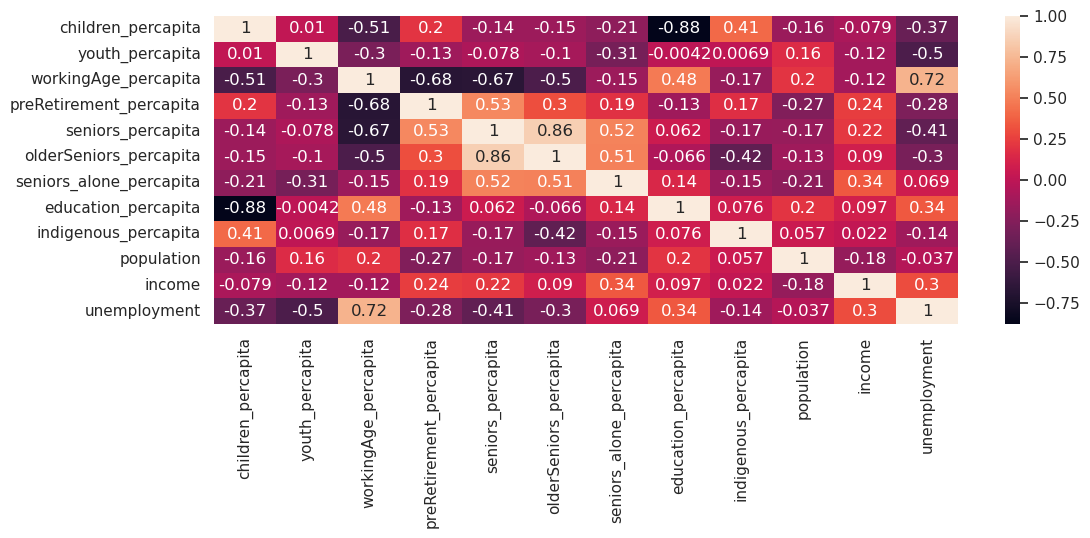

In [ ]:
predictors = [s + '_percapita' for s in population_variables] + ['population', 'income', 'unemployment']
# create correlation matrix to observe multicollinearity
matrix = crime_regions[predictors].corr(method = 'pearson', min_periods = 1)
sns.heatmap(matrix, annot = True)
plt.show()

In [ ]:
crime_regions.columns

Index(['neighbourhood', 'longitute', 'latitude', 'geometry', 'Assault_2016',
       'Assault_Rate2016', 'AutoTheft_2016', 'AutoTheft_Rate2016',
       'BreakAndEnter_2016', 'BreakAndEnter_Rate2016', 'Robbery_2016',
       'Robbery_Rate2016', 'TheftOver_2016', 'TheftOver_Rate2016',
       'Homicide_2016', 'Homicide_Rate2016', 'Shootings_2016',
       'Shootings_Rate2016', 'TotalCrimes_2016', 'TotalCrimes_Rate2016',
       'PropertyCrimes_2016', 'PropertyCrimes_Rate2016', 'ViolenceCrimes_2016',
       'ViolenceCrimes_Rate2016', 'population', 'children', 'youth',
       'workingAge', 'preRetirement', 'seniors', 'olderSeniors',
       'seniors_alone', 'income', 'education', 'indigenous', 'unemployment',
       'children_percapita', 'youth_percapita', 'workingAge_percapita',
       'preRetirement_percapita', 'seniors_percapita',
       'olderSeniors_percapita', 'seniors_alone_percapita',
       'education_percapita', 'indigenous_percapita'],
      dtype='object')

In [ ]:
# PROPERTY CRIME RATE FEATURE SELECTION
# Rosa's stats stuff
lreg = LinearRegression()

# define predictors to be tested and dependent variable
x = crime_regions[predictors]
y = crime_regions['PropertyCrimes_Rate2016']

sfs1 = sfs(lreg, k_features=5, forward=False, verbose=1, scoring='neg_mean_squared_error')
sfsfit = sfs1.fit(x, y)
idx = sfsfit.k_feature_idx_
pd.DataFrame.from_dict(sfsfit.get_metric_dict()).T

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.2s finished
Features: 11/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.2s finished
Features: 10/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
Features: 9/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s finished
Features: 8/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s finished
Features: 7/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s finished
Features: 6/5[Parallel(n_jo

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
12,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)","[-58783.63639977581, -31736.33565014934, -6244...",-47255.821048,"(children_percapita, youth_percapita, workingA...",20861.65172,16231.073777,8115.536888
11,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)","[-46065.80862919676, -31808.046798497133, -601...",-43792.528686,"(children_percapita, youth_percapita, workingA...",19849.162305,15443.322614,7721.661307
10,"(0, 1, 2, 3, 4, 5, 6, 8, 9, 10)","[-46335.70410272368, -32143.28457086725, -6047...",-42007.066277,"(children_percapita, youth_percapita, workingA...",17634.682417,13720.382028,6860.191014
9,"(0, 1, 2, 3, 4, 5, 6, 8, 9)","[-43499.84805611375, -31771.2524532307, -60395...",-41314.54796,"(children_percapita, youth_percapita, workingA...",17495.258229,13611.905273,6805.952637
8,"(0, 2, 3, 4, 5, 6, 8, 9)","[-41786.02329702078, -31855.115464239898, -604...",-40954.957436,"(children_percapita, workingAge_percapita, pre...",17535.503748,13643.217655,6821.608827
7,"(0, 2, 3, 4, 5, 6, 8)","[-41443.43856607076, -31400.14531197953, -6038...",-40689.019432,"(children_percapita, workingAge_percapita, pre...",17755.428656,13814.326704,6907.163352
6,"(0, 2, 3, 4, 5, 8)","[-41353.680099238045, -31369.734049738738, -60...",-40619.924144,"(children_percapita, workingAge_percapita, pre...",17775.674775,13830.078873,6915.039436
5,"(0, 2, 3, 4, 8)","[-42713.76319326616, -31391.32562658743, -6156...",-41134.556102,"(children_percapita, workingAge_percapita, pre...",19560.229564,15218.523126,7609.261563


In [ ]:
predictors_list = []
for x in idx:
    predictors_list.append(predictors[x])

x = crime_regions[predictors_list]
x = sm.add_constant(x)
    
model = sm.OLS(y, x).fit()
model.summary()

In [ ]:
# VIOLENT CRIME RATE FEATURE SELECTION
# david's stats stuff
lreg = LinearRegression()

# define predictors to be tested and dependent variable
x = crime_regions[predictors]
y = crime_regions['ViolenceCrimes_Rate2016']

x = sm.add_constant(x)

sfs1 = sfs(lreg, k_features=5, forward=False, verbose=1, scoring='neg_mean_squared_error')
sfsfit = sfs1.fit(x, y)
idx = sfsfit.k_feature_idx_
pd.DataFrame.from_dict(sfsfit.get_metric_dict()).T

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.2s finished
Features: 12/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.2s finished
Features: 11/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.2s finished
Features: 10/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
Features: 9/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s finished
Features: 8/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s finished
Features: 7/5[Parallel(n_j

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
13,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)","[-75276.92192427054, -51282.049852479904, -719...",-60899.09669,"(const, children_percapita, youth_percapita, w...",16556.399471,12881.441263,6440.720632
12,"(0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)","[-50928.6595148977, -51317.96671966376, -71608...",-55565.937307,"(const, youth_percapita, workingAge_percapita,...",13520.616932,10519.499313,5259.749657
11,"(0, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12)","[-49175.33695310138, -50780.001752256554, -702...",-54695.976695,"(const, youth_percapita, workingAge_percapita,...",13207.820119,10276.132765,5138.066383
10,"(0, 2, 3, 4, 6, 7, 8, 9, 11, 12)","[-49345.257798953695, -51122.36107280113, -688...",-54434.41327,"(const, youth_percapita, workingAge_percapita,...",13028.520482,10136.631557,5068.315778
9,"(0, 2, 3, 4, 6, 7, 9, 11, 12)","[-48065.92796566432, -52021.78275669356, -7000...",-54299.326068,"(const, youth_percapita, workingAge_percapita,...",12648.052005,9840.614156,4920.307078
8,"(0, 2, 3, 6, 7, 9, 11, 12)","[-48853.06416635526, -48210.84645823421, -7038...",-54012.120195,"(const, youth_percapita, workingAge_percapita,...",12940.940984,10068.491731,5034.245866
7,"(0, 2, 3, 6, 7, 9, 11)","[-50872.246617176104, -47243.49653562211, -647...",-53900.948199,"(const, youth_percapita, workingAge_percapita,...",10256.577222,7979.965529,3989.982764
6,"(2, 3, 6, 7, 9, 11)","[-50872.24661717593, -47243.49653562233, -6474...",-53900.948199,"(youth_percapita, workingAge_percapita, olderS...",10256.577222,7979.965529,3989.982764
5,"(2, 6, 7, 9, 11)","[-53087.18277534209, -47567.92658893117, -7528...",-56667.530309,"(youth_percapita, olderSeniors_percapita, seni...",13687.45039,10649.301411,5324.650705


In [ ]:
predictors_list = []
for x in idx:
    predictors_list.append(predictors[x])

print(predictors_list)

['workingAge_percapita', 'seniors_alone_percapita', 'education_percapita', 'population', 'unemployment']


In [ ]:
%%capture --no-display
# Heat Map of Total Crime Rate by Neighbourhood in Toronto
fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of Total Crime Rate (per 100,000) \nby Neighbourhood in Toronto, Ontario', fontdict={'fontsize': '40', 'fontweight' : '3'})

color = 'Oranges'
vmin, vmax = 0, crime_regions['TotalCrimes_Rate2016'].max()
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

crime_regions.plot('TotalCrimes_Rate2016', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))
for idx, row in crime_regions.iterrows():
    if(row['TotalCrimes_Rate2016'] > 2000):
        plt.annotate(text=row['neighbourhood'], xy=(row['longitute'], row['latitude']),
                 horizontalalignment='center', fontsize='large', color='black', wrap=True)
plt.show()

In [ ]:
%%capture --no-display
# Heat Map of Property Related Crimes by Neighbourhood in Toronto

fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of Property Related Crimes by Neighbourhood in Toronto, Ontario', fontdict={'fontsize': '40', 'fontweight' : '3'})

color = 'Blues'
vmin, vmax = 0, crime_regions['PropertyCrimes_Rate2016'].max()
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

crime_regions.plot('PropertyCrimes_Rate2016', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))
for idx, row in crime_regions.iterrows():
    if(row['PropertyCrimes_Rate2016'] > 1000):
        plt.annotate(text=row['neighbourhood'], xy=(row['longitute'], row['latitude']),
                 horizontalalignment='center', fontsize='large', color='black', wrap=True)
plt.show()

In [ ]:
%%capture --no-display
# Heat Map of Violence Related Crimes by Neighbourhood in Toronto

fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of Violent Crimes by Neighbourhood in Toronto, Ontario', fontdict={'fontsize': '40', 'fontweight' : '3'})

color = 'Greens'
vmin, vmax = 0, crime_regions['ViolenceCrimes_Rate2016'].max()
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

crime_regions.plot('ViolenceCrimes_Rate2016', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))
for idx, row in crime_regions.iterrows():
    if(row['ViolenceCrimes_Rate2016'] > 1000):
        plt.annotate(text=row['neighbourhood'], xy=(row['longitute'], row['latitude']),
                 horizontalalignment='center', fontsize='large', color='black', wrap=True)
plt.show()

In [ ]:
# assaults top 10 bar graph
crime_regions = crime_regions.sort_values(['TotalCrimes_Rate2016'], ascending=False)

fig, ax = plt.subplots()

ax.bar(crime_regions['neighbourhood'].iloc[:10], crime_regions['TotalCrimes_Rate2016'].iloc[:10])

ax.set_ylabel('Total Crime Rate \n(per 100,000 people)')
ax.set_title('Number of total crimes committed by neighbourhood (top 10)')

plt.show()

In [ ]:
plt.rc('figure', figsize=(12, 4))

x = np.arange(len(crime_regions['neighbourhood'].iloc[:5]))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

#rects1 = ax.bar(x - width/2, men_means, width, label='Men')
assault = ax.bar(x - width/2, crime_regions['Assault_2016'].iloc[:5], width, label='Assault')
homicide = ax.bar(x + width/2, crime_regions['BreakAndEnter_2016'].iloc[:5], width, label='BreakAndEnter')
#rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Crimes')
ax.set_title('Assault/Break and Enter by neighbourhood')
ax.set_xticks(x, crime_regions['neighbourhood'].iloc[:5])
ax.legend()

ax.bar_label(assault, padding=3)
ax.bar_label(homicide, padding=3)

fig.tight_layout()

plt.show()

In [ ]:
crime_regions = crime_regions.sort_values(['TotalCrimes_2016'], ascending=False)

plt.plot(crime_regions['neighbourhood'].iloc[:5],crime_regions['Assault_2016'].iloc[:5])
plt.plot(crime_regions['neighbourhood'].iloc[:5],crime_regions['AutoTheft_2016'].iloc[:5])
plt.plot(crime_regions['neighbourhood'].iloc[:5],crime_regions['BreakAndEnter_2016'].iloc[:5])
plt.plot(crime_regions['neighbourhood'].iloc[:5],crime_regions['Robbery_2016'].iloc[:5])
plt.plot(crime_regions['neighbourhood'].iloc[:5],crime_regions['TheftOver_2016'].iloc[:5])
plt.plot(crime_regions['neighbourhood'].iloc[:5],crime_regions['Homicide_2016'].iloc[:5])
plt.plot(crime_regions['neighbourhood'].iloc[:5],crime_regions['Shootings_2016'].iloc[:5])


In [ ]:
%%capture --no-display
# make smaller plots so we can visually compare them
crimes_of_interest_column_names = ["Assault_Rate2016", "AutoTheft_Rate2016", "BreakAndEnter_Rate2016", 
                                   "Robbery_Rate2016", "TheftOver_Rate2016", "Homicide_Rate2016", "Shootings_Rate2016"]
#colors = plt.cm.Sequential
colors = ["Oranges", "Blues", "Reds", "Greens"]

fig_width = 5
fig_height = 5

# make the plots
fig, axs = plt.subplots(ncols=len(crimes_of_interest_column_names), figsize=(fig_width * len(crimes_of_interest_column_names), fig_height))
# common settings for all plots:
for ax in axs:
    ax.axis('off')

# unique settings:
for i in range(0, len(crimes_of_interest_column_names)):
    crime_column = crimes_of_interest_column_names[i]
    #todo: fix title crime name
    axs[i].set_title(f"{crime_column}", fontdict={'fontsize': '10', 'fontweight' : '3'})

    color = colors[i % len(colors)]
    vmin, vmax = 0, crime_regions[crime_column].max()
    scalar_mappable = mpltlib.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=color)
    
    #cbar = fig.colorbar(scalar_mappable)
    #cbar.ax.tick_params(labelsize=14)

    crime_regions.plot(crime_column, cmap=color, linewidth=0.8, ax=axs[i], edgecolor='0.8', figsize=(fig_width, fig_height))

    
plt.show()
    
#####################
discard = '''
# make the plot
fig, ax = plt.subplots(1, figsize=(10,5))
ax.axis('off')
ax.set_title('Heat Map of Unemployment', fontdict={'fontsize': '10', 'fontweight' : '3'})

color = 'Blues'
vmin, vmax = 0, 231
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

merged.plot('Assault_2016', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(10,5))

plt.show()
'''

In [ ]:
%%capture --no-display
# make smaller plots so we can visually compare them
crimes_of_interest_column_names = ["Assault_2016", "AutoTheft_2016", "BreakAndEnter_2016", "Robbery_2016", "TheftOver_2016", "Homicide_2016", "Shootings_2016"]
#colors = plt.cm.Sequential
colors = ["Oranges", "Blues", "Reds", "Greens"]

fig_width = 5
fig_height = 5

# make the plots
fig, axs = plt.subplots(ncols=len(crimes_of_interest_column_names), figsize=(fig_width * len(crimes_of_interest_column_names), fig_height))
# common settings for all plots:
for ax in axs:
    ax.axis('off')

# unique settings:
for i in range(0, len(crimes_of_interest_column_names)):
    crime_column = crimes_of_interest_column_names[i]
    #todo: fix title crime name
    axs[i].set_title(f"{crime_column}", fontdict={'fontsize': '10', 'fontweight' : '3'})

    color = colors[i % len(colors)]
    vmin, vmax = 0, crime_regions[crime_column].max()
    scalar_mappable = mpltlib.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=color)
    
    #cbar = fig.colorbar(scalar_mappable)
    #cbar.ax.tick_params(labelsize=14)

    crime_regions.plot(crime_column, cmap=color, linewidth=0.8, ax=axs[i], edgecolor='0.8', figsize=(fig_width, fig_height))

    
plt.show()
    

In [ ]:
# Unpivot the crime dataframe
crime_years = pd.melt(crime_raw, id_vars=['OBJECTID','Neighbourhood','Hood_ID','F2020_Population_Projection','Shape__Area','Shape__Length'])


In [ ]:
# adjust the variable column to split
crime_years['variable'] = crime_years['variable'].str.replace('_Rate', 'Rate_')


In [ ]:
# split variable column into crime_type and year
crime_years[['crime_type','year']] = crime_years['variable'].str.split('_', expand=True)


In [ ]:
# remove columns that are not used
crime_years = crime_years.drop('OBJECTID', axis=1)
crime_years = crime_years.drop('Hood_ID', axis=1)
crime_years = crime_years.drop('F2020_Population_Projection', axis=1)
crime_years = crime_years.drop('Shape__Area', axis=1)
crime_years = crime_years.drop('Shape__Length', axis=1)
crime_years = crime_years.drop('variable', axis=1)


In [ ]:
crime_years